In [ ]:
from typing import Annotated, Sequence, TypedDict
from dotenv import load_dotenv
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage,ToolMessage,AIMessage
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from functools import wraps
from logger import logger
import os



load_dotenv()

True

In [ ]:

add_tool={
    "type": "function",
        "function": {
            "name": "add",
            "description": "addtion function that adds 2 numbers together",
            "parameters": {
                "type": "object",
                "properties": {
                    "a": {"type":"integer"}, 
                    "b": {"type":"integer"}, 
                
                    
                },
                "required": ["a", "b"]
            }
        }
}

sub_tool={
    "type": "function",
        "function": {
            "name": "sub",
            "description": "subtraction function that subtract 2 numbers together",
            "parameters": {
                "type": "object",
                "properties": {
                    "a": {"type":"integer"}, 
                    "b": {"type":"integer"}, 
                
                    
                },
                "required": ["a", "b"]
            }
        }
}

multiply_tool={
    "type": "function",
        "function": {
            "name": "multiply",
            "description": "multiplication function that multiply 2 numbers together",
            "parameters": {
                "type": "object",
                "properties": {
                    "a": {"type":"integer"}, 
                    "b": {"type":"integer"}, 
                
                    
                },
                "required": ["a", "b"]
            }
        }
}
divide_tool={
    "type": "function",
        "function": {
            "name": "divide",
            "description": "divide function that divide 2 numbers together",
            "parameters": {
                "type": "object",
                "properties": {
                    "a": {"type":"integer"}, 
                    "b": {"type":"integer"}, 
                
                    
                },
                "required": ["a", "b"]
            }
        }
}

def add_fun(a:int,b:int):
    return a+b
def sub_fun(a:int,b:int):
    return a-b
def multiply_fun(a:int,b:int):
    return a*b
def divide_fun(a:int,b:int):
    return a/b

TOOLS=[add_tool,sub_tool,multiply_tool,divide_tool]

In [ ]:
api_key = os.getenv("OPENAI_API_KEY")
if not api_key:
    raise ValueError("OPENAI_API_KEY not found")

llm = ChatOpenAI(
    model="gpt-4o-mini",
).bind_tools(tools=TOOLS)

In [ ]:

import json

TOOL_EXECUTERS={
    "add": add_fun,
    "sub": sub_fun,
    "multiply": multiply_fun,
    "divide": divide_fun
}

In [ ]:
class AgentState(TypedDict):
    messages:Annotated[Sequence,add_messages]
def llm_call(state:AgentState)->AgentState:

    system_prompt=SystemMessage(content=
           """
                Instructions:
                1) your are a calculator assistant .you must always call  tools for operations
                2)only use one tool at a time and wait for tool result before calling another tool
                3)use the previous tool result if required 
                4)you must never assum the result you must only use the result that are returned by the tool

                STRICT NOTE : Never make up your answer

"""                 )    
    
    msg=[system_prompt] + state["messages"]
    response=llm.invoke(msg)
    return {"messages":state["messages"]+[response]}

def should_continue(state:AgentState):
    last=state["messages"][-1]
    if isinstance(last,AIMessage):
        if last.tool_calls:
            return "tools"
        else:
            return"end"


def execute_tools(state: AgentState)-> AgentState:
    last = state['messages'][-1]
    print(f"--execute_tools message--")
    print(f"{last}")
    print(f"---END--")
    tool_calls = last.additional_kwargs.get("tool_calls",[])

    if len(tool_calls)>1:
        raise ValueError("Multiple tools calls are not allowed")
    new_messages = []

    for call in tool_calls:
        name = call["function"]["name"]
        print(f"name--------->{name}")
        args = json.loads(call["function"]["arguments"])
        print(f"args---->{args}")
        result = TOOL_EXECUTERS[name](**args)
        print(f"toolex_result---->{result}")
        tool_msg = ToolMessage(
            tool_call_id = call["id"],
            content=f"Tool  result of {name}({args['a']},{args['b']})={result}"
        )
        print(f"----tool_msg--{tool_msg}---END")
        new_messages.append(tool_msg)
        print(f"----updated tool_msg---{new_messages}---END")
    return {"messages": state["messages"] + new_messages}


In [ ]:
graph = StateGraph(AgentState)
graph.add_node("agent", llm_call)
graph.add_node("tools",execute_tools)
graph.set_entry_point("agent")
graph.add_conditional_edges("agent", should_continue, {"tools": "tools", "end" : END })
graph.add_edge("tools","agent")
app = graph.compile()

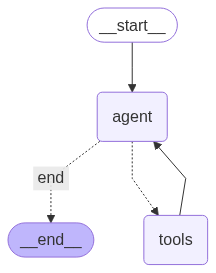

In [ ]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [ ]:
def print_statement(statement):
    for s in statement:
        message=s["messages"][-1]
        if isinstance(message,tuple):
            print(message)
        else:
            message.pretty_print()

input={"messages":[HumanMessage(content="multiply 10,20 and add 20 to the result.")]} 
print_statement(app.stream(input,stream_mode="values"))               

================================ Human Message =================================

multiply 10,20 and add 20 to the result.
================================== Ai Message ==================================
Tool Calls:
  multiply (call_VqIkt2VtIIVk7cyqAm7hM0ZR)
 Call ID: call_VqIkt2VtIIVk7cyqAm7hM0ZR
  Args:
    a: 10
    b: 20
--execute_tools message--
content='' additional_kwargs={'tool_calls': [{'id': 'call_VqIkt2VtIIVk7cyqAm7hM0ZR', 'function': {'arguments': '{"a":10,"b":20}', 'name': 'multiply'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 230, 'total_tokens': 247, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BokeT4s2uCp8kF3KYxhg1Xpb1O358', 'service_tier': 'defa